# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
RANDOM = 42


# 1. Загрузка и подготовка данных

Загрузим данные

In [2]:
zero_frame = pd.read_csv("geo_data_0.csv")
first_frame = pd.read_csv("geo_data_1.csv")
second_frame = pd.read_csv("geo_data_2.csv")

In [3]:
def display_info(isFrame,**kwargs):
    """Функция структурированного вывода переданной информации
    
    Формат оглавления ключа:
        #################
        #   Имя_Ключа   #
        #################
    """
    # Воспользуемся display,если передается фрейм и print, если передаются отсальные типы
    if isFrame:
        out_func = display
    else: 
        out_func = print
        
    # Обработаем все переданные параметры с их ключами   
    for frame_name, args in kwargs.items():
        # Создадим строку с названием обрабатываемого ключа
        name_string = "#   "+ str(frame_name) + "   #"
        # Измерим длину получившегося названия, чтобы в дальнейшем создать окантовку для него
        len_label = len(name_string)
        
        # Выведем оглавление согласну формату указанному в описании
        print("#"*len_label)
        print(name_string)
        print("#"*len_label)
        print()
        
        #обработаем и выведем параметры переданные для вывода
        for info_string,element in args.items():
            if not info_string:
                out_func(element)
            else:
                out_func(info_string,element)
        print()

In [4]:
display_info(True,
             Zero_Frame = {'':zero_frame.head()},
             First_Frame = {'':first_frame.head()},
             Second_Frame = {'':second_frame.head()})

##################
#   Zero_Frame   #
##################



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



###################
#   First_Frame   #
###################



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



####################
#   Second_Frame   #
####################



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Проведем первичное изучение данных


In [5]:
print("####################")
print("#    Zero Frame    #")
print("####################")
print()
print(zero_frame.info())
print()
print("####################")
print("#    First Frame   #")
print("####################")
print()
print(first_frame.info())
print()
print("####################")
print("#    Second Frame  #")
print("####################")
print()
print(second_frame.info())

####################
#    Zero Frame    #
####################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

####################
#    First Frame   #
####################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ M

In [6]:
display_info(False,
             Zero_Frame = {'Количество дубликатов:':zero_frame.duplicated().sum()},
             First_Frame = {'Количество дубликатов:':first_frame.duplicated().sum()},
             Second_Frame = {'Количество дубликатов:':second_frame.duplicated().sum()})

##################
#   Zero_Frame   #
##################

Количество дубликатов: 0

###################
#   First_Frame   #
###################

Количество дубликатов: 0

####################
#   Second_Frame   #
####################

Количество дубликатов: 0



In [7]:
display_info(True,
             Zero_Frame = {'':zero_frame.describe()},
             First_Frame = {'':first_frame.describe()},
             Second_Frame = {'':second_frame.describe()})

##################
#   Zero_Frame   #
##################



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



###################
#   First_Frame   #
###################



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



####################
#   Second_Frame   #
####################



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


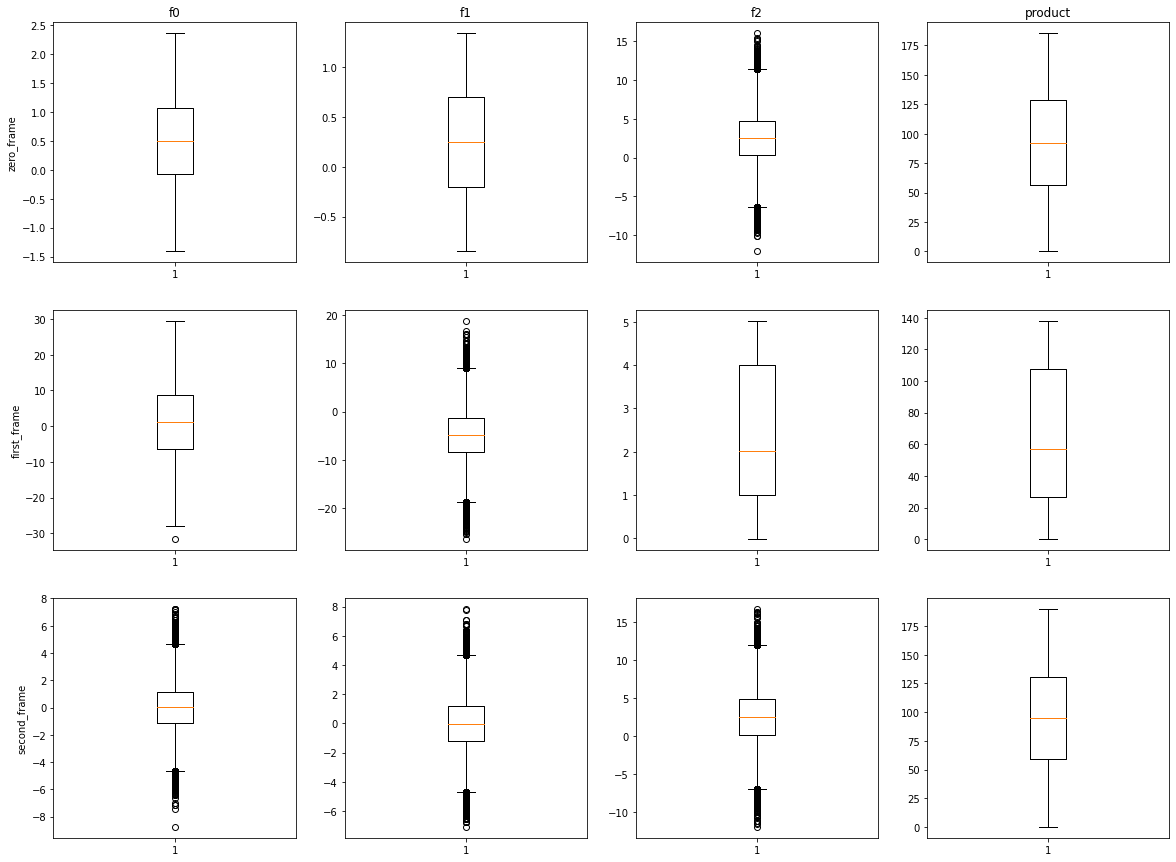

In [8]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["zero_frame","first_frame","second_frame"]
num_columns = zero_frame.columns[1:]
num_columns_with_columns = zip(zero_frame.columns[1:],range(4))
all_frames_with_rows = zip([zero_frame,first_frame,second_frame],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Заметим, что в некоторых стобцах есть данные выходящие за границы. Эти данные будут мешать моделе обучаться отвлекая еею Поэтому их необходимо удалить.
Выпишем необходимые столбцы для обработки в формате (фрейм, столбец):
1. (zero_frame,"f2")
1. (first_frame,"f1")
1. (second_frame,"f0")
1. (second_frame,"f1")
1. (second_frame,"f2")

Исправим данные

In [9]:
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [10]:
noise_data = [(zero_frame,"f2"),
 (first_frame,"f1"),
 (second_frame,"f0"),
 (second_frame,"f1"),
 (second_frame,"f2")]

for frame,column in noise_data:
    indexes = remove_ouliers(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682
Количество строк, выбранных для удаления:  582


Выборки пострадали не сильно, в первых двух потери составили менее 1%, в последней же потеря данных составила 2%

In [11]:
zero_frame = zero_frame.reset_index(drop = True)
first_frame = first_frame.reset_index(drop = True)
second_frame = second_frame.reset_index(drop = True)

Проверим корреляцию между признаками

In [12]:
display_info(True,
             Zero_Frame = {'':zero_frame.corr()},
             First_Frame = {'':first_frame.corr()},
             Second_Frame = {'':second_frame.corr()})

##################
#   Zero_Frame   #
##################



,f0,f1,f2,product
f0,1.000000,-0.440716,-0.003339,0.143591
f1,-0.440716,1.000000,0.001098,-0.192748
f2,-0.003339,0.001098,1.000000,0.480159
product,0.143591,-0.192748,0.480159,1.000000



###################
#   First_Frame   #
###################



,f0,f1,f2,product
f0,1.000000,0.178877,-0.001670,-0.030389
f1,0.178877,1.000000,-0.002756,-0.010174
f2,-0.001670,-0.002756,1.000000,0.999397
product,-0.030389,-0.010174,0.999397,1.000000



####################
#   Second_Frame   #
####################



,f0,f1,f2,product
f0,1.000000,0.000649,0.000473,-0.002962
f1,0.000649,1.000000,0.000710,-0.000895
f2,0.000473,0.000710,1.000000,0.441211
product,-0.002962,-0.000895,0.441211,1.000000


Заметим, что в нулевом фрейме признаки f0 и f1 отрицательно коррелируют относительно друг друга и f2 слабо положительно коррелирует с целевым признаком. Так же в первом фрейме очень сильно коррелирует целевой признак и f2. Во втором фрейме так же есть коррелирующие признаки, такие как f2 и product.

Если в случе с первым фреймом все достаточно понятно, там очень высокая корреляция и признак f2 следует удалить, то вот в случае с другими двумя выборками стоит опираться на результатб который мы получим на моделях, Следовательно необходимо подготовить 7 выборок:
1. Нулевая со всеми столбцами
1. Нулевая без f1
1. Нулевая без f2
1. Нулевая без f1 и f2
1. Первая без f2
1. Вторая без f2
1. Вторая со всеми столбцами

In [13]:
zero_frame_out_f1 = zero_frame.drop(["f1"],axis = 1)
zero_frame_out_f2 = zero_frame.drop(["f2"],axis = 1)
zero_frame_out_f12 = zero_frame.drop(["f1","f2"],axis = 1)
first_frame_out_f2 = first_frame.drop(["f2"],axis = 1)
second_frame_out_f2 = second_frame.drop(["f2"],axis = 1)

Результаты первичного анализа:
1. Пропуски - отсутсвуют
2. Типы столбцов - корректны
3. Названия столбцов - корректны 
1. Дубликаты - отсутсвуют
1. Объем запасов - положительный 
1. Выбросы - удалены
1. Коррелирующие признаки - учтены

# 2. Обучение и проверка модели

In [14]:
array_name = ["zero_frame",
              "second_frame",
              "zero_frame_out_f1",
              "zero_frame_out_f2",
              "zero_frame_out_f12",
              "first_frame_out_f2",
              "second_frame_out_f2"]

array_frame = [zero_frame,
              second_frame,
              zero_frame_out_f1,
              zero_frame_out_f2,
              zero_frame_out_f12,
              first_frame_out_f2,
              second_frame_out_f2]

data_dict = {"pipelines":{},"scores":{},"valid":{}}

for frame, name in zip(array_frame,array_name):
    
    features = frame.drop(["id","product"], axis = 1)
    target = frame["product"]
    
    new_pipeline = make_pipeline(StandardScaler(),LinearRegression())
    
    
    (features_train,
    features_valid,
    target_train,
    target_valid) = train_test_split(features,
                                     target,
                                     test_size = 0.25,
                                     random_state = RANDOM)
    data_dict['valid'][name] = (features_valid,target_valid)
    new_pipeline.fit(features_train,target_train)
    
    data_dict['pipelines'][name] = new_pipeline
    data_dict['scores'][name] = mean_squared_error(target_valid,
                                                   new_pipeline.predict(features_valid))**0.5
    
    

In [15]:
data_dict['scores']

{'zero_frame': 37.815104778634264,
 'second_frame': 40.12959008344122,
 'zero_frame_out_f1': 38.38103474294198,
 'zero_frame_out_f2': 43.51509319803277,
 'zero_frame_out_f12': 43.97170725395929,
 'first_frame_out_f2': 45.99719288701953,
 'second_frame_out_f2': 44.766957840837804}

Выборка с минимальной ошибкой: 
1. Нулевой регион: 'zero_frame'
1. Первый регион: "first_frame_out_f2"
1. Второй регион: 'second_frame'

In [16]:
best_model_zero = data_dict['pipelines']['zero_frame']
best_model_first = data_dict['pipelines']['first_frame_out_f2']
best_model_second = data_dict['pipelines']['second_frame']

predicted_values_zero = best_model_zero.predict(data_dict['valid']['zero_frame'][0])
predicted_values_first = best_model_first.predict(data_dict['valid']['first_frame_out_f2'][0])
predicted_values_second = best_model_second.predict(data_dict['valid']['second_frame'][0])

RMSE_model_zero = (mean_squared_error(data_dict['valid']['zero_frame'][1],predicted_values_zero))**0.5
RMSE_model_first = (mean_squared_error(data_dict['valid']['first_frame_out_f2'][1],predicted_values_first))**0.5
RMSE_model_second = (mean_squared_error(data_dict['valid']['second_frame'][1],predicted_values_second))**0.5

In [17]:
display_info(False,
             Zero_Frame = {'Средний запас:':predicted_values_zero.mean(),
                           "RMSE модели:":RMSE_model_zero},
             First_Frame = {'Средний запас:':predicted_values_first.mean(),
                            "RMSE модели:":RMSE_model_first},
             Second_Frame = {'Средний запас:':predicted_values_second.mean(),
                             "RMSE модели:":RMSE_model_second})

##################
#   Zero_Frame   #
##################

Средний запас: 92.3505469646708
RMSE модели: 37.815104778634264

###################
#   First_Frame   #
###################

Средний запас: 68.90081167842224
RMSE модели: 45.99719288701953

####################
#   Second_Frame   #
####################

Средний запас: 94.95178110761829
RMSE модели: 40.12959008344122



### Вывод:
- Нулевой регион:
    - Ошибка в нулевом регионе самая маленькая, но по средниму объему запасов регион на втором месте 
- Первый регион:
    - Проигрывает другим регионам и по показателю средней шибки и по среднему объему запасов
- Второй регион:
    - Самый большой средний объем запасов, но по ошибке регион на втором месте


# 3. Подготовка к расчёту прибыли

In [18]:
budget_per_region = 10*(10**9)
pre_max_points = 500
final_max_points = 200
price_per_barrel = 450
damages_threshold =  0.025
non_damage_point = (budget_per_region/(price_per_barrel*(10**3)))/(final_max_points)

In [19]:
print("Достаточный объем добычи для безубыточной разработки",round(non_damage_point,2))

Достаточный объем добычи для безубыточной разработки 111.11


посмотрим распледеление значений в районах

In [20]:
display_info(True,
             Zero_Frame = {'':zero_frame.describe()},
             First_Frame = {'':first_frame.describe()},
             Second_Frame = {'':second_frame.describe()})

##################
#   Zero_Frame   #
##################



,f0,f1,f2,product
count,99494.000000,99494.000000,99494.000000,99494.000000
mean,0.500570,0.250044,2.503399,92.500677
std,0.871838,0.504437,3.181196,44.229330
min,-1.408605,-0.848218,-6.352956,0.000000
25%,-0.072378,-0.201063,0.301496,56.567678
50%,0.502606,0.250032,2.516336,91.842533
75%,1.073729,0.700574,4.704256,128.517876
max,2.362331,1.343769,11.353804,185.364347



###################
#   First_Frame   #
###################



,f0,f1,f2,product
count,99364.000000,99364.000000,99364.000000,99364.000000
mean,1.139661,-4.803101,2.493961,68.809919
std,8.966349,4.984107,1.703241,45.934941
min,-31.609576,-18.667777,-0.018144,0.000000
25%,-6.300689,-8.249871,1.000016,26.953261
50%,1.150044,-4.816643,2.011374,57.085625
75%,8.621015,-1.363538,3.999893,107.813044
max,29.421755,9.050688,5.019721,137.945408



####################
#   Second_Frame   #
####################



,f0,f1,f2,product
count,98003.000000,98003.000000,98003.000000,98003.000000
mean,0.000788,-0.002182,2.494648,94.785072
std,1.679981,1.681475,3.389780,44.685282
min,-4.640830,-4.676782,-6.944602,0.000000
25%,-1.153136,-1.164226,0.147699,59.330119
50%,0.008893,-0.009345,2.482845,94.696578
75%,1.148220,1.155001,4.841025,130.319425
max,4.637965,4.670610,11.945919,190.029838


In [21]:
print("16% скважин содержат больше сырья, чем ",round(first_frame["product"].quantile(0.84),2))

16% скважин содержат больше сырья, чем  134.77


Минимальное количество баррелей нефти для безубыточной разработки составило 111.(1)  

В тоже время максимальное средний объем в регионах равен 94.
Если обратить внимание на распределение объема запасов по району, то можно увидеть, что в нулевом и втором райне 25% скважин подходят под минимальный порог(учитывая объемы выборок 25% это более 20 000 скважин)  

В первом регионе ситуация немного хуже, но там так же достаточно скважин, для неубыточной добычи(порадка 16% скважин удолитворяют пороговому значению)

# 4. Расчёт прибыли и рисков 

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован